In [1]:
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()

In [2]:
import torch
import torchaudio
import pickle
with open('/data/ephraim/datasets/known_noise/undiff_exps2/exp_p_try/try_models.pickle', 'rb') as handle:
    params_dict = pickle.load(handle)

In [16]:
from create_exp_p_train import GaussianARStepModel,sample_ar_noise,get_named_beta_schedule
device = "cuda"
t=0
state_dict = params_dict['nets'][t]
model = GaussianARStepModel(channels=64, kernel=3, n_layers=4).to(device)
model.load_state_dict(state_dict)
model.eval()
print("ok")

ok


In [17]:
import torchaudio
clean ,sr=  torchaudio.load(r"/data/ephraim/datasets/known_noise/undiff_exps2/exp_p_try/clean_wav/clean_fileid_0.wav")  
print("clean.shape:", clean.shape)  
clean = clean.to(device)
y = clean + sample_ar_noise(clean.shape[0], clean.shape[1], 0.9, .1, device)
eps = torch.randn_like(y)

betas = torch.tensor(get_named_beta_schedule("linear", 200),
                         dtype=torch.float32, device=device)
alphas = 1 - betas
a_bar = torch.cumprod(alphas, 0)
sqrt_a_bar     = torch.sqrt(a_bar)           # (T,)
sqrt_one_minus = torch.sqrt(1 - a_bar)

x_t = sqrt_a_bar[t] * y + sqrt_one_minus[t] * eps
mu, log_sigma = model(x_t, y) 

clean.shape: torch.Size([1, 160000])


In [25]:
from tqdm import tqdm
long = 2000
window = 2000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = model.to(device)
cur_input = y.clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)
with torch.no_grad():
# cur_input = cur_train[0,0,:window].view(1,1,-1)
    for i in tqdm(range(y.shape[1]-window)):
        if i >long:
            continue

        mu, log_sigma = model(x_t.view(1,1,-1)[0,0,:window+i+1].view(1,-1),y.view(1,1,-1)[0,0,:window+i+1].view(1,-1))
        sig = torch.exp(log_sigma)
        mu_ = mu[0,-1]
        sig_ = sig[0,-1]
        
        mu_array[window+i] = mu_
        sig_array[window+i] = sig_
        added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
        # print(mu_,sig_,added)
        cur_input[0,0,window+i+1] = added

        torch.cuda.empty_cache()

tensor(0.5317, device='cuda:0')
tensor(0., device='cuda:0')
torch.Size([1, 1, 160000])


  0%|          | 0/158000 [00:00<?, ?it/s]

100%|██████████| 158000/158000 [00:27<00:00, 5805.00it/s]


In [40]:
t2=100
state_dict = params_dict['nets'][t2]
model_10 = GaussianARStepModel(channels=64, kernel=3, n_layers=4).to(device)
model_10.load_state_dict(state_dict)
x_10 = sqrt_a_bar[t2] * y + sqrt_one_minus[t2] * eps

IndexError: list index out of range

In [41]:
from tqdm import tqdm
long = 2000
window = 2000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model_10 = model_10.to(device)
cur_input_10 = y.clone().view(1,1,-1)
cur_input_10[0,0,window+1:] = 0
print(cur_input_10[0,0,window])
print(cur_input_10[0,0,window+1])
cur_input_10 = cur_input_10.to(device, dtype=torch.float)
print(cur_input_10.shape)
with torch.no_grad():
# cur_input = cur_train[0,0,:window].view(1,1,-1)
    for i in tqdm(range(y.shape[1]-window)):
        if i >long:
            continue

        mu, log_sigma = model_10(x_10.view(1,1,-1)[0,0,:window+i+1].view(1,-1),y.view(1,1,-1)[0,0,:window+i+1].view(1,-1))
        sig = torch.exp(log_sigma)
        mu_ = mu[0,-1]
        sig_ = sig[0,-1]
        
        mu_array[window+i] = mu_
        sig_array[window+i] = sig_
        added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
        # print(mu_,sig_,added)
        cur_input_10[0,0,window+i+1] = added

        torch.cuda.empty_cache()

tensor(0.5317, device='cuda:0')
tensor(0., device='cuda:0')
torch.Size([1, 1, 160000])


  0%|          | 0/158000 [00:00<?, ?it/s]

100%|██████████| 158000/158000 [00:36<00:00, 4344.01it/s] 


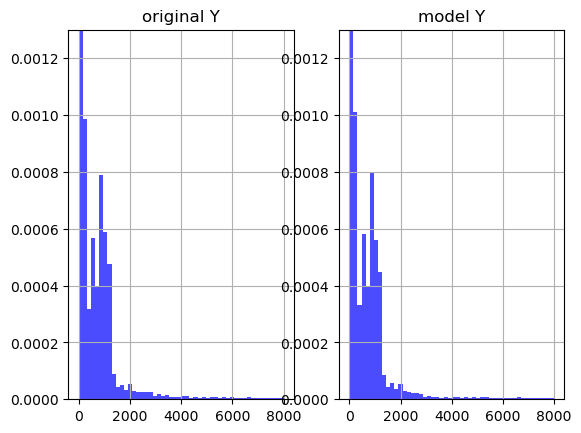

In [35]:
import scipy.signal as signal
from matplotlib import pyplot as plt

freqs1, magnitudes1 = signal.welch(y[0,window:window+long].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[0,0,window:window+long].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Y')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Y')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)

plt.show()

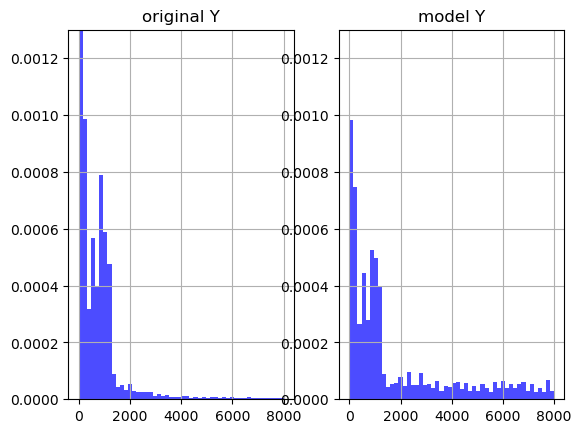

In [ ]:
import scipy.signal as signal  #10
from matplotlib import pyplot as plt

freqs1, magnitudes1 = signal.welch(y[0,window:window+long].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input_10[0,0,window:window+long].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Y')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Y')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)

plt.show()

In [44]:
from IPython import display
display.display(display.Audio(y[0,window:window+long].cpu().view(1,-1), rate=sr))

In [ ]:
from IPython import display #100
display.display(display.Audio(cur_input_10[0,0,window:window+long].cpu().view(1,-1), rate=sr))

In [46]:
from IPython import display
display.display(display.Audio(cur_input[0,0,window:window+long].cpu().view(1,-1), rate=sr))

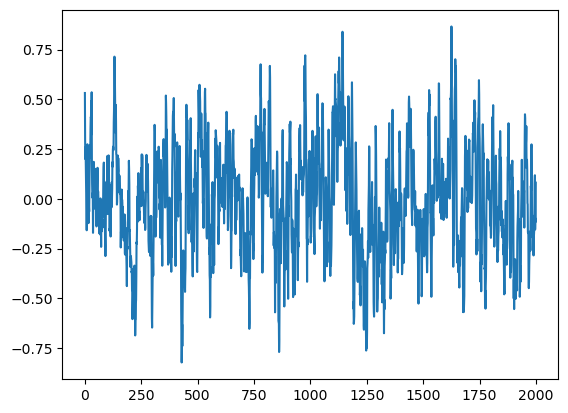

In [33]:
plot_this(y[0,window:window+long].cpu().detach().numpy(), title='model Y')

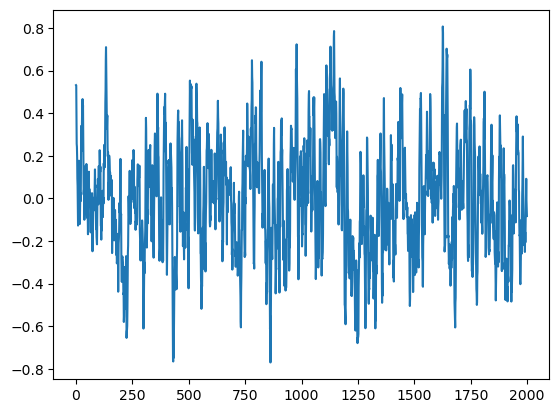

In [30]:
plot_this(cur_input[0,0,window:window+long].cpu().detach().numpy(), title='model Y')

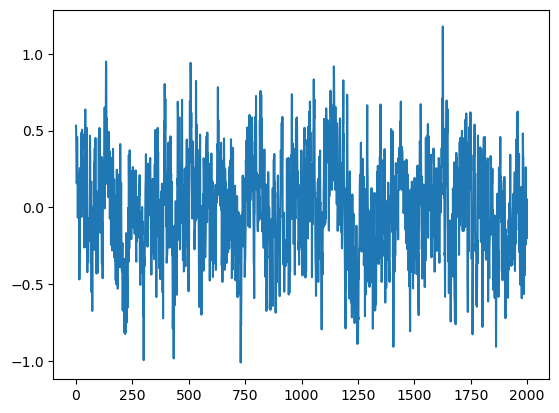

In [47]:
plot_this(cur_input_10[0,0,window:window+long].cpu().detach().numpy(), title='model Y')

In [48]:
import numpy as np  
def calc_likelihood(expected_means, expected_stds, wav_tensor, verbose=False):
    wav_tensor = wav_tensor.squeeze(axis=1)
    means_=expected_means.squeeze(axis=1)
    stds_ = expected_stds.squeeze(axis=1)

    exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
    param_all = 1/(np.sqrt(2*np.pi)*stds_)
    model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
    model_likelihood2 = torch.sum(exp_all, axis=-1) 

    if verbose:
        print("model_likelihood1: ", model_likelihood1)
        print("model_likelihood2: ", model_likelihood2)
    likelihood = model_likelihood1 + model_likelihood2
    return likelihood.mean()

In [54]:
import math
mu, log_sigma = model(x_t, y) 
inv_var = torch.exp(-2 * log_sigma)
nll = ((log_sigma + 0.5 * math.log(2 * math.pi))
        + 0.5 * inv_var * (y - mu) ** 2).sum()
print("nll:", nll.mean())

nll: tensor(-87913.8203, device='cuda:0', grad_fn=<MeanBackward0>)


In [51]:
std = torch.exp(log_sigma)
ll = calc_likelihood(mu, std, y)
print("ll:", -ll)

ll: tensor(-87913.8125, device='cuda:0', grad_fn=<NegBackward0>)
